In [ ]:
import numpy as np
import pandas as pd
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

In [ ]:
train_data = pd.read_csv('/content/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/fashion-mnist_test.csv')

In [ ]:
train_data.shape
test_data.shape
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0])
test_Y = np.array(test_data.iloc[:,0])

In [ ]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [ ]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [ ]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
#-----

In [ ]:
from tensorflow.keras.utils import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [ ]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [ ]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [ ]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 5s 6ms/step


In [ ]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [ ]:
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [ ]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import ELU, PReLU, LeakyReLU

In [ ]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 267,786
Trainable params: 267,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [ ]:
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 1.4695 - acc: 0.4519 - val_loss: 1.2432 - val_acc: 0.5473 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 1.1055 - acc: 0.5947 - val_loss: 1.0541 - val_acc: 0.6033 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9869 - acc: 0.6388 - val_loss: 1.0570 - val_acc: 0.5912 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9390 - acc: 0.6550 - val_loss: 0.9587 - val_acc: 0.6357 - lr: 0.0010
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9021 - acc: 0.6683 - val_loss: 0.9241 - val_acc: 0.6609 - lr: 0.0010
Epoch 6/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8773 - acc: 0.6774 - val_loss: 0.8942 - val_acc: 0.6704 - lr: 0.0010
Epoch 7/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.8629 - acc: 0.6831 - val_loss: 0.

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_features_flat, test_Y_one_hot, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)



Baseline test accuracy: 0.7538999915122986


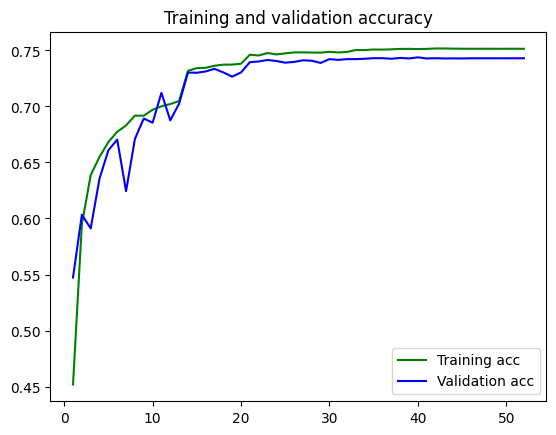

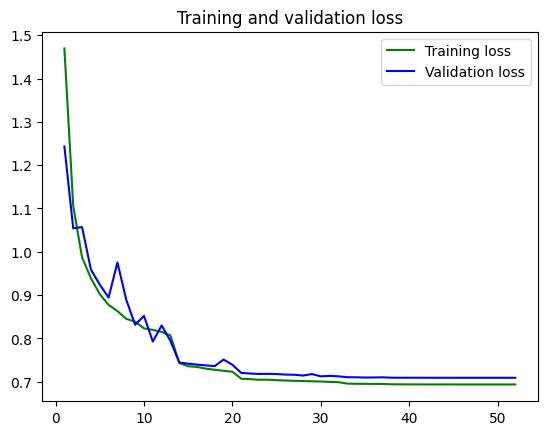

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
acc

[0.4518541693687439,
 0.5946875214576721,
 0.6387708187103271,
 0.6549999713897705,
 0.6682708263397217,
 0.6773958206176758,
 0.6831041574478149,
 0.6918333172798157,
 0.6917708516120911,
 0.6970624923706055,
 0.700124979019165,
 0.7021458148956299,
 0.7048333287239075,
 0.7318124771118164,
 0.7342291474342346,
 0.734499990940094,
 0.7363333106040955,
 0.7373124957084656,
 0.737375020980835,
 0.7381250262260437,
 0.7461458444595337,
 0.745520830154419,
 0.7477083206176758,
 0.7464583516120911,
 0.7473750114440918,
 0.7482500076293945,
 0.7482916712760925,
 0.7481250166893005,
 0.7480416893959045,
 0.7487499713897705,
 0.7482500076293945,
 0.7486249804496765,
 0.750374972820282,
 0.7503125071525574,
 0.7508333325386047,
 0.7507500052452087,
 0.7509999871253967,
 0.7513541579246521,
 0.7513958215713501,
 0.7512500286102295,
 0.7513750195503235,
 0.7517499923706055,
 0.7517499923706055,
 0.7516250014305115,
 0.7515208125114441,
 0.7514791488647461,
 0.7514791488647461,
 0.751520812511444

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard

In [ ]:
! pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_X.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense (  (None, 512)              524802    
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_leaky_r  (None, 512)              1         
 e_lu (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_dense_1  (None, 10)               10252     
  (PruneLowMagnitude)                                            
                                                                 
Total params: 535,055
Trainable params: 267,786
Non-trainable params: 267,269
_________________________________________________________________


In [ ]:
import keras

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import random




import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization
from keras.layers import MaxPool2D,Dropout
from keras.layers import Flatten
from keras.layers import Dense
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# define input data to CNN（28×28×1）
input_shape = (28, 28, 1)

# transform for Deep Learning
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
num_classes = 10
y_train_dl = keras.utils.to_categorical(y_train, num_classes)
y_test_dl = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=input_shape, filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=128,activation="relu"))
# model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=num_classes, activation="softmax"))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                        

In [ ]:
from keras import optimizers
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
epochs = 10
history = model.fit(x_train, y_train_dl,
                    batch_size=64, #Number of simultaneous learning
                    epochs=epochs, #Number of train
                    verbose=1, # halfway output
                    validation_data=(x_test, y_test_dl)) # data for validation

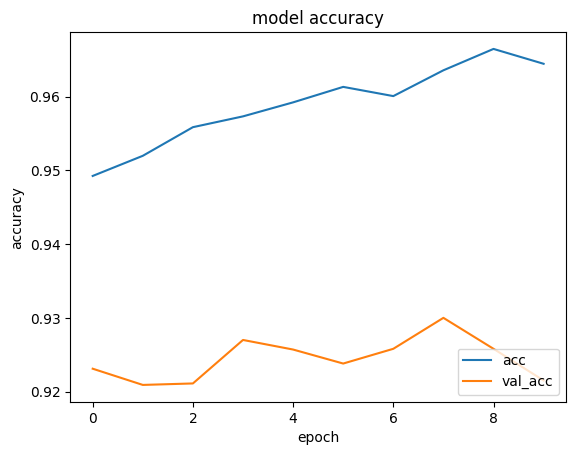

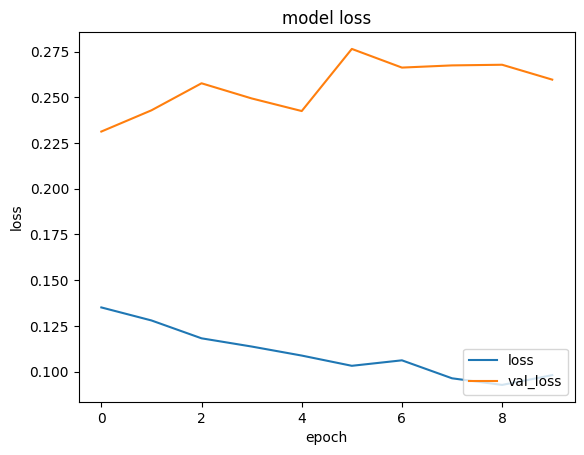

fashion-mnist_test.csv	fashion-mnist_train.csv  history.png  sample_data


<Figure size 640x480 with 0 Axes>

In [ ]:
## Visuarize train history

def plot_history(history):
    # print(history.history.keys())
    from matplotlib import pyplot as plt

    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

    ## saveimage
    plt.savefig("history.png")

# plot
plot_history(history)
!ls
#download
#from google.colab import files
#files.download("history.png")